In [1]:
get_ipython().magic('matplotlib inline')
get_ipython().magic('config InlineBackend.figure_format = "retina"')

import matplotlib.pyplot as pl

from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 200
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import os
import sys
from collections import OrderedDict
import numpy as np
import pandas as pd
from scipy import stats
from configobj import ConfigObj
from astropy import constants as c
from astropy import units as u
import pprint

import limbdark

pp = pprint.PrettyPrinter(indent=2)

def map_int(x):
    return list(map(int, x))

def map_float(x):
    return list(map(float, x))

sys.path.append('..')
from transitfit.gp import GPTransitFit
from transitfit.util import mad_outliers, get_init_params, u_to_q, rho

In [3]:
def bin_data(data, binsize_min):
    cols = ['c{}'.format(i) for i in range(data.shape[1])]
    df = pd.DataFrame(OrderedDict(zip(cols,data.T)))

    binsize = binsize_min / (60 * 24)
    bins = np.arange(df['c0'].min(), df['c0'].max(), binsize)
    groups = df.groupby(np.digitize(df['c0'], bins))
    df_binned = groups.mean().copy()
    return df_binned.values

datasets = OrderedDict()

Ndata raw: 1099
Ndata clipped: 2
Ndata final: 236


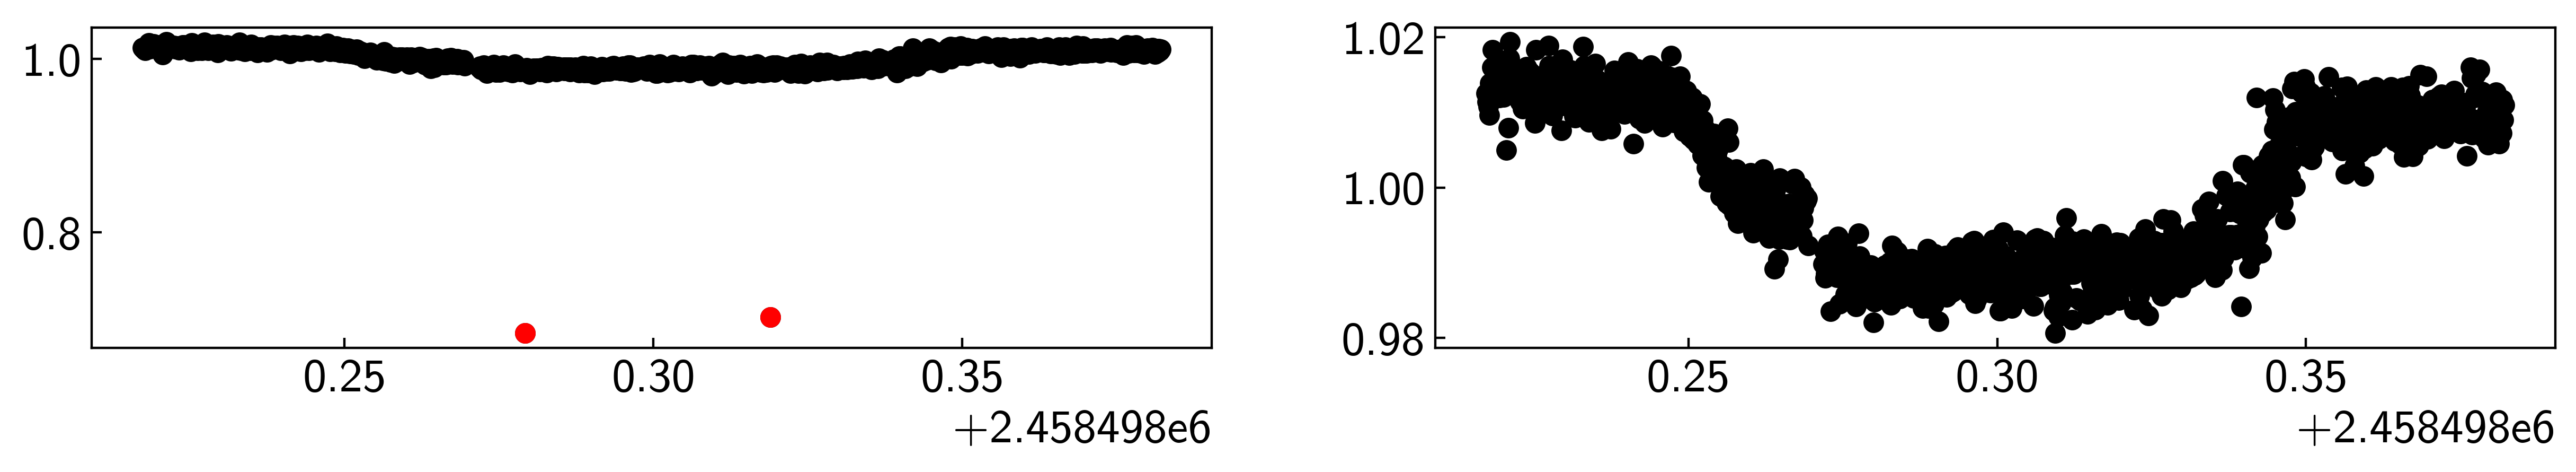

In [4]:
#################################
fp = '../data/LC_457.95000_428.84000.txt'
band = 'r'
t_range = None
binsize_min = 1

df = pd.read_table(fp, delim_whitespace=True, names='t f x y peak'.split()).dropna()
print("Ndata raw: {}".format(df.shape[0]))
time, flux, cenx, ceny, peak = df.values.T
time, flux = df['t f'.split()].values.T
time += 2400000.5
flux /= np.median(flux)

aux = np.c_[
    np.ones_like(time),
    time-time.min(), 
    (time-time.min())**2, 
    cenx/cenx.mean(), 
    ceny/ceny.mean(), 
#     peak/peak.mean()
]
#################################

fig, axs = pl.subplots(1, 2, figsize=(15,2))

ax = axs[0]
ax.plot(time, flux, marker='o', linestyle='none', color='k')

idx = mad_outliers(flux)
print("Ndata clipped: {}".format(idx.sum()))
ax.plot(time[idx], flux[idx], marker='o', linestyle='none', color='r')
t, f, aux = time[~idx], flux[~idx], aux[~idx]

data = np.c_[t, f, aux]

if binsize_min is not None:
    data = bin_data(data, binsize_min)

datasets[band] = data
print("Ndata final: {}".format(data.shape[0]))

if t_range is not None:
    t_min, t_max = t_range
    t = datasets[band][:,0]
    idx = (t > t_min) & (t < t_max)
    datasets[band] = datasets[band][idx]
    ax.axvline(t_min, color='b')
    ax.axvline(t_max, color='b')

ax = axs[1]
ax.plot(t, f, marker='o', linestyle='none', color='k')

In [5]:
planets = {
    '211929937.01':
    {
        'per': 3.476643,
        'rprs': 0.126,
        't0': 2309.41227 + 2454833,
        't14': 0.106
    }
}

star = {
    'feh': [0.09, 0.05],
    'logg': [4.53, 0.03],
    'rad': [0.85, 0.02],
    'teff': [5300, 80]
}


************r-band************
{ 'b': 0.5,
  'k': 0.126,
  'ls': -4.5841319897164876,
  'p': 3.476643,
  'priors': { 'ld': ( 0.50729999999999997,
                      0.026363639108436841,
                      0.2089,
                      0.023641996645865172),
              'per': (3.476643, 0.0001),
              'rho': (2.0560665591771099, 0.15119193297915057),
              't0': (2457142.41227, 0.001),
              't14': (0.106, 0.005)},
  'q1': 0.51294243999999989,
  'q2': 0.35416084892488131,
  'r': 2.0560665591771099,
  't0': 2457142.41227,
  't14': 0.106}
-851.0680002442673
True
-1185.1366641330733


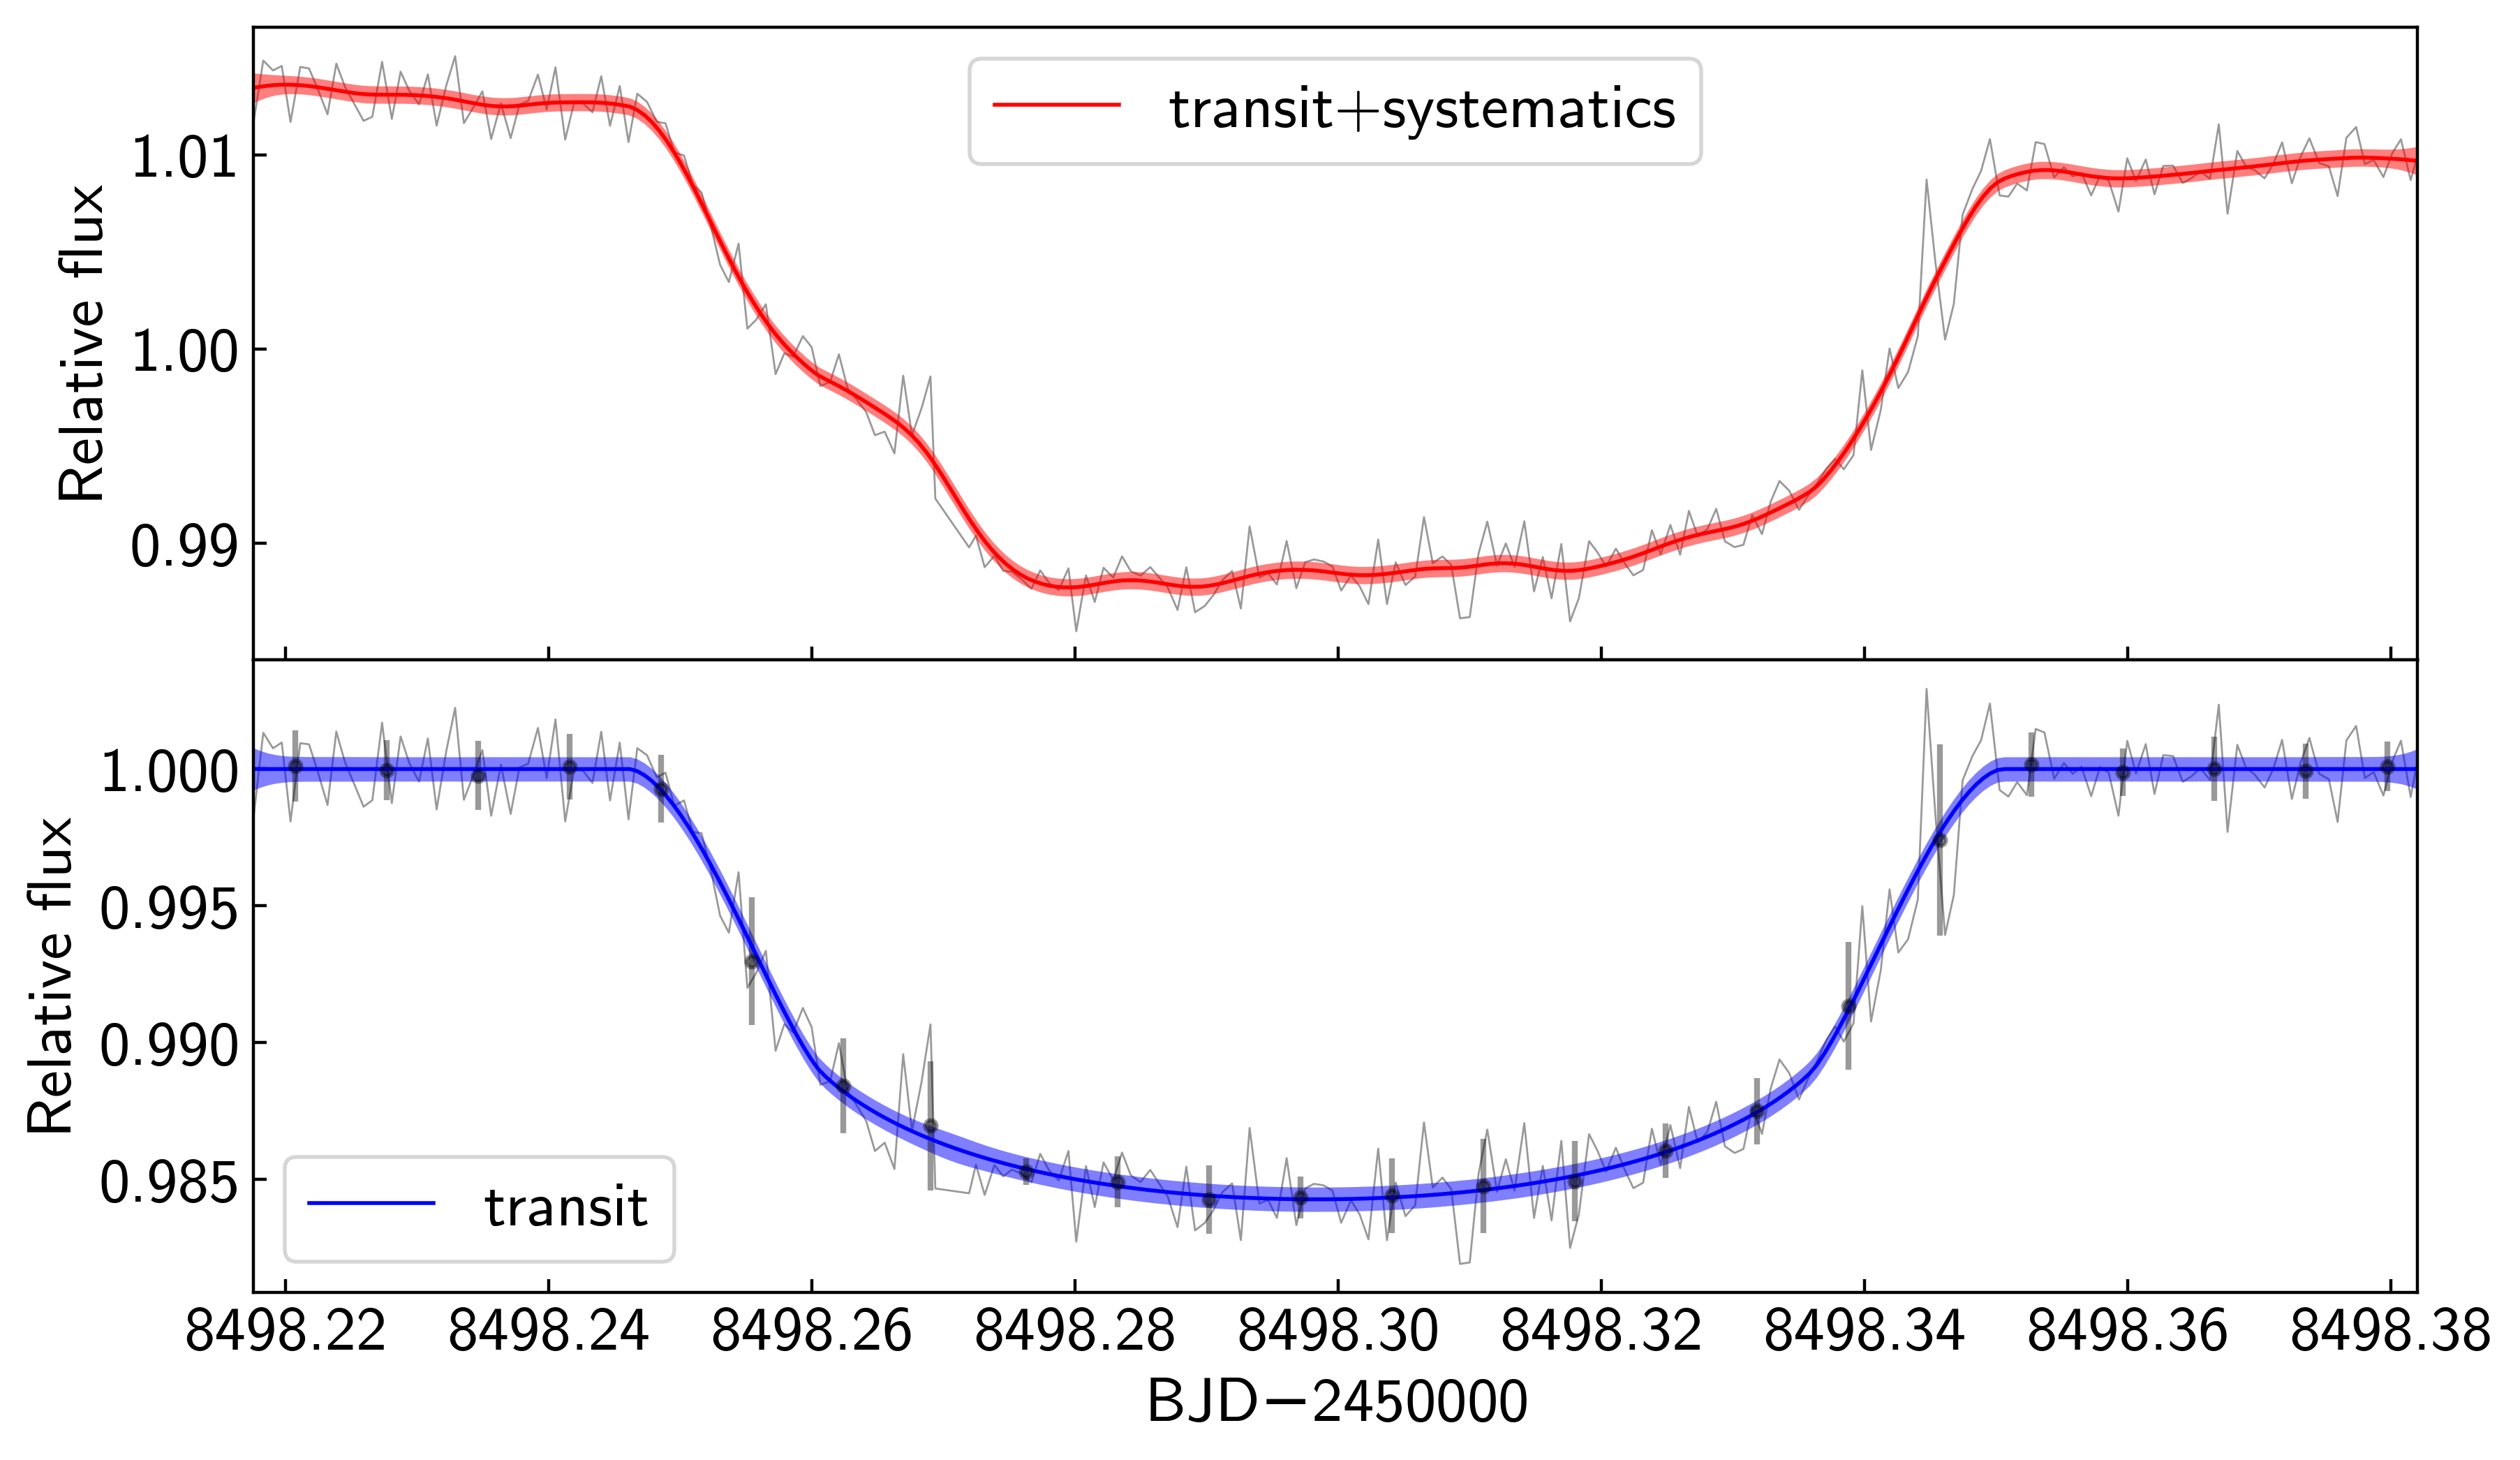

In [6]:
pl_name = list(planets.keys())[0]
planet = planets[pl_name]
per, t0, t14, rprs = [planet.get(key) for key in 'per t0 t14 rprs'.split()]

# tc = min([datasets[k][:,0].min() for k in datasets.keys()])
# while t0 < tc.min():
#     t0 += per

# ephem priors
t0p = t0, 0.001
perp = per, 0.0001
t14p = t14, 0.005

# compute density prior
logg = map_float(star['logg'])
rad = map_float(star['rad'])
n = 10000
rad_s = rad[0] + np.random.randn(n) * rad[1]
logg_s = logg[0] + np.random.randn(n) * logg[1]
rho_s = rho(logg_s, rad_s)
rhop = rho_s.mean(), rho_s.std()


print("\n{:*^30s}".format(band+'-band'))
    
teff, logg, feh = [star.get(k) for k in 'teff logg feh'.split()]
if band == 'r': 
    band_name = band + '*'
else:
    band_name = band

ldp = limbdark.claret(band_name, teff[0], teff[1], logg[0], logg[1], feh[0], feh[1])
u1, u2 = ldp[0], ldp[2]
q1, q2 = u_to_q(u1, u2)

priors = dict(ld=ldp, t0=t0p, per=perp, t14=t14p, rho=rhop)

t = datasets[band][:,0]
f = datasets[band][:,1]
aux = datasets[band][:,2:]

init_params = get_init_params(per, t0, t14, rprs, rho=rhop[0], b=0.5, q1=q1, q2=q2)
init_params['priors'] = priors
init_params['ls'] = np.log(f.std())

pp.pprint(init_params)

gpfit = GPTransitFit(t, f, init_params)
gpfit.init_gp()
gpfit.fit_map()
gpfit.plot_map(c1='r', c2='b')